## Deep Learning Term Project for ECG (DIL700)

# Iteration 5

# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
from keras import Sequential
from keras.layers import Convolution1D, MaxPool1D, Flatten, Dense, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')

import datetime

# Custom functions
from general_functions import *

# Loading dataset

    Number of Samples: 14552
    Number of Categories: 2
    Sampling Frequency: 125Hz
    Data Source: Physionet's PTB Diagnostic Database

This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs. (https://www.kaggle.com/datasets/shayanfazeli/heartbeat)

In [2]:
normal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_normal.csv',header=None)
abnormal_df = pd.read_csv('./Dataset_ptbdb/ptbdb_abnormal.csv',header=None)
# Combine to a full dataset
full_df = pd.concat([normal_df, abnormal_df], axis=0, ignore_index=True)

In [3]:
print('Number of samples per class: \n')
print('Normal:                 ', len(full_df[full_df[187]==0]))
print('Abnormal:               ', len(full_df[full_df[187]==1]))

Number of samples per class: 

Normal:                  4046
Abnormal:                10506


In [4]:
normal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4041,1.000000,0.929586,0.503550,0.293491,0.169822,0.159763,0.130769,0.125444,0.137278,0.111243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4042,1.000000,0.637579,0.154837,0.061983,0.088965,0.083374,0.065143,0.057365,0.060039,0.060039,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4043,1.000000,0.872574,0.465071,0.232212,0.126132,0.155886,0.174644,0.190168,0.203752,0.168823,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4044,0.915983,0.529373,0.288406,0.144536,0.171802,0.180669,0.177566,0.176458,0.178896,0.180448,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Normal only contains class 0 --> healthy
normal_df[187].unique()

array([0.])

In [6]:
abnormal_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10502,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10503,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10504,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
# Abnormal only contains class 1 --> not healthy
abnormal_df[187].unique()

array([1.])

In [8]:
full_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14547,0.981409,1.000000,0.559171,0.287093,0.196639,0.204862,0.215946,0.243833,0.242760,0.250268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14548,0.906250,0.922379,0.878024,0.810484,0.712702,0.667339,0.608871,0.527218,0.480847,0.442540,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14549,1.000000,0.867971,0.674122,0.470332,0.296987,0.169307,0.077664,0.081392,0.074868,0.089779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14550,1.000000,0.984672,0.658888,0.556394,0.446809,0.395790,0.315260,0.276367,0.261039,0.258522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
# Full contains both classes
full_df[187].unique()

array([0., 1.])

In [10]:
labels = ['Normal', 'Abnormal']

# Preparation

In [11]:
from sklearn.model_selection import train_test_split

# split the data into features and target
X = full_df.drop(187, axis=1)
y = full_df[187]

# Split data into training and testing sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

In [12]:
# validation data
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.20, stratify=y_train_full, random_state=42)

In [13]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,177,178,179,180,181,182,183,184,185,186
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.052197,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [14]:
train_df = X_train.copy()
train_df[187] = y_train
valid_df = X_valid.copy()
valid_df[187] = y_valid
test_df = X_test.copy()	
test_df[187] = y_test

train_df

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
12529,1.000000,0.829819,0.467386,0.203531,0.208926,0.182442,0.073075,0.078470,0.067680,0.049044,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
8792,0.905602,0.734440,0.354772,0.154046,0.122925,0.165975,0.176349,0.177905,0.182054,0.176867,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
13408,1.000000,0.808531,0.117995,0.109900,0.061021,0.031756,0.022416,0.011519,0.006849,0.027086,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2746,1.000000,0.529361,0.199217,0.094824,0.107873,0.109178,0.088734,0.079600,0.074815,0.075685,...,0.055676,0.055676,0.057851,0.060896,0.067856,0.066551,0.0,0.0,0.0,0.0
366,1.000000,0.700711,0.349063,0.106658,0.077569,0.301228,0.371041,0.371687,0.404008,0.411765,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13768,0.888561,0.430425,0.423939,0.391509,0.364976,0.339623,0.290094,0.295401,0.312500,0.303066,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
5609,1.000000,0.338724,0.017969,0.000000,0.415993,0.477987,0.510332,0.546271,0.587601,0.543576,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0
2442,1.000000,0.551974,0.231668,0.007252,0.023368,0.076551,0.101128,0.092264,0.089847,0.087429,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
11291,0.988811,0.376690,0.000000,0.014918,0.049417,0.059207,0.076457,0.055478,0.035431,0.037296,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0


In [15]:
print('Number of samples in training data:')
print('Normal:                              ', len(train_df[train_df[187]==0]))
print('Abnormal:                            ', len(train_df[train_df[187]==1]))

Number of samples in training data:
Normal:                               2589
Abnormal:                             6723


In [16]:
print('Number of samples in validation data:')
print('Normal:                              ', len(valid_df[valid_df[187]==0]))
print('Abnormal:                            ', len(valid_df[valid_df[187]==1]))

Number of samples in validation data:
Normal:                               648
Abnormal:                             1681


In [17]:
print('Number of samples in test data:')
print('Normal:                              ', len(test_df[test_df[187]==0]))
print('Abnormal:                            ', len(test_df[test_df[187]==1]))

Number of samples in test data:
Normal:                               809
Abnormal:                             2102


Same ratio of the two classes in both the datasets

# ANN

# Dropout with Rate 0.08

In [18]:
name = 'ann_dropout_008'

In [19]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.08))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 2s 4ms/step - loss: 0.4543 - accuracy: 0.7776 - val_loss: 0.3757 - val_accuracy: 0.8248
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3783 - accuracy: 0.8197 - val_loss: 0.3145 - val_accuracy: 0.8562
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3441 - accuracy: 0.8378 - val_loss: 0.2831 - val_accuracy: 0.8720
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3039 - accuracy: 0.8624 - val_loss: 0.3075 - val_accuracy: 0.8678
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2894 - accuracy: 0.8721 - val_loss: 0.2574 - val_accuracy: 0.8866
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2601 - accuracy: 0.8873 - val_loss: 0.2276 - val_accuracy: 0.9141
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 0.2639 - accuracy: 0.8894 - val_loss: 0.2495 - val_accuracy: 0.8918

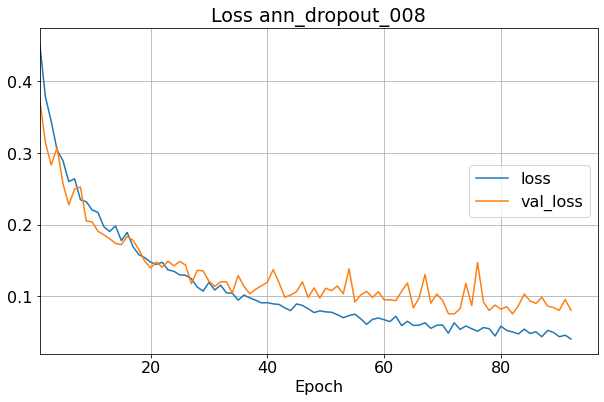

In [21]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

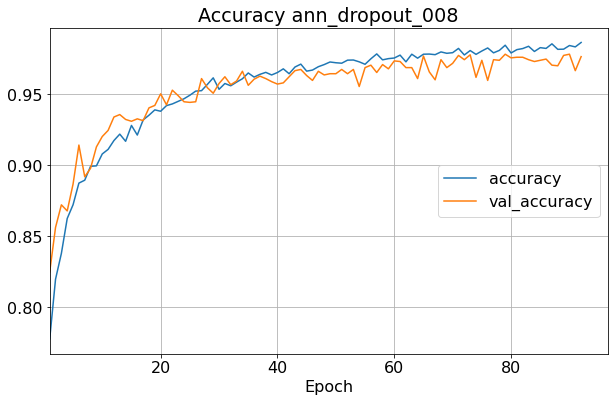

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [23]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.96908


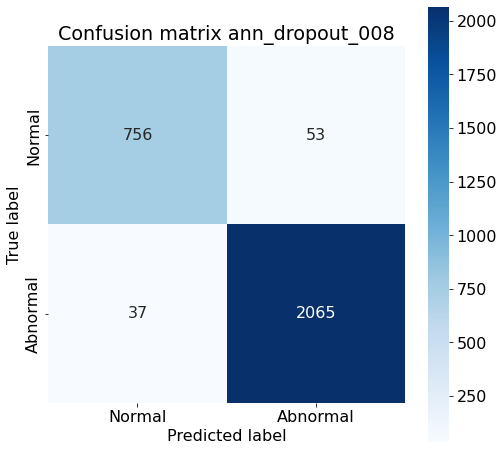

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [25]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.93448702 0.98239772]
Macro/average accuracy:  0.9584423687370554


In [26]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9533    0.9345    0.9438       809
    Abnormal     0.9750    0.9824    0.9787      2102

    accuracy                         0.9691      2911
   macro avg     0.9642    0.9584    0.9612      2911
weighted avg     0.9690    0.9691    0.9690      2911



### False Positive Rate

In [27]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  37
Percentage of sick persons that are classified as normal:  1.7602283539486203 %


# Dropout with Rate 0.10

In [28]:
name = 'ann_dropout_010'

In [29]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.10))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 2s 5ms/step - loss: 0.4694 - accuracy: 0.7606 - val_loss: 0.3535 - val_accuracy: 0.8261
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3797 - accuracy: 0.8136 - val_loss: 0.3795 - val_accuracy: 0.8270
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3544 - accuracy: 0.8329 - val_loss: 0.3454 - val_accuracy: 0.8557
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3235 - accuracy: 0.8498 - val_loss: 0.2863 - val_accuracy: 0.8720
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3062 - accuracy: 0.8643 - val_loss: 0.2858 - val_accuracy: 0.8746
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2887 - accuracy: 0.8666 - val_loss: 0.2460 - val_accuracy: 0.9004
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2734 - accuracy: 0.8814 - val_loss: 0.2375 - val_accuracy: 0.8987

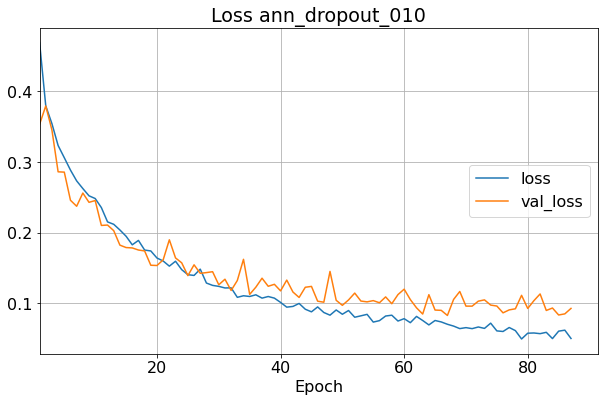

In [31]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

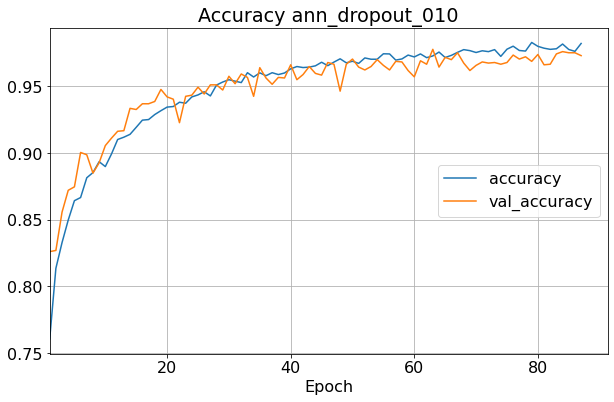

In [32]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [33]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.97046


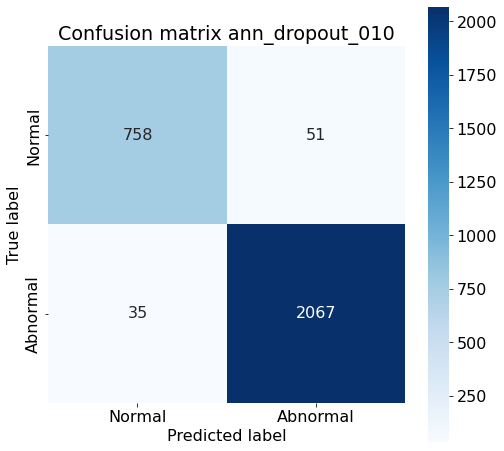

In [34]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [35]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.93695921 0.98334919]
Macro/average accuracy:  0.9601542000731542


In [36]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9559    0.9370    0.9463       809
    Abnormal     0.9759    0.9833    0.9796      2102

    accuracy                         0.9705      2911
   macro avg     0.9659    0.9602    0.9630      2911
weighted avg     0.9703    0.9705    0.9704      2911



### False Positive Rate

In [37]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  35
Percentage of sick persons that are classified as normal:  1.6650808753568032 %


# Dropout with Rate 0.12

In [38]:
name = 'ann_dropout_012'

In [39]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.12))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 0.4685 - accuracy: 0.7651 - val_loss: 0.4049 - val_accuracy: 0.7991
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3999 - accuracy: 0.8053 - val_loss: 0.3616 - val_accuracy: 0.8231
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3703 - accuracy: 0.8242 - val_loss: 0.3071 - val_accuracy: 0.8583
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3306 - accuracy: 0.8488 - val_loss: 0.2856 - val_accuracy: 0.8815
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3117 - accuracy: 0.8574 - val_loss: 0.2678 - val_accuracy: 0.8888
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3067 - accuracy: 0.8610 - val_loss: 0.2617 - val_accuracy: 0.8909
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2775 - accuracy: 0.8770 - val_loss: 0.2422 - val_accuracy: 0.8987

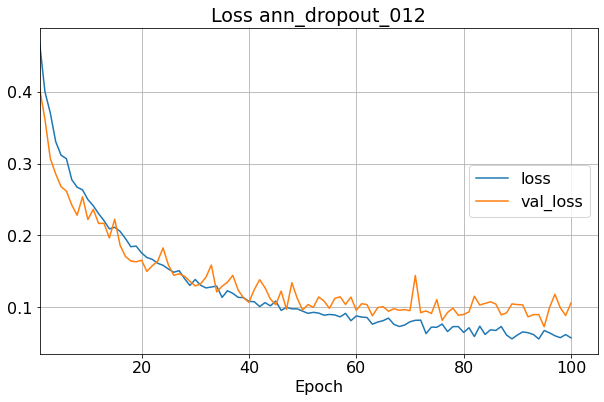

In [41]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

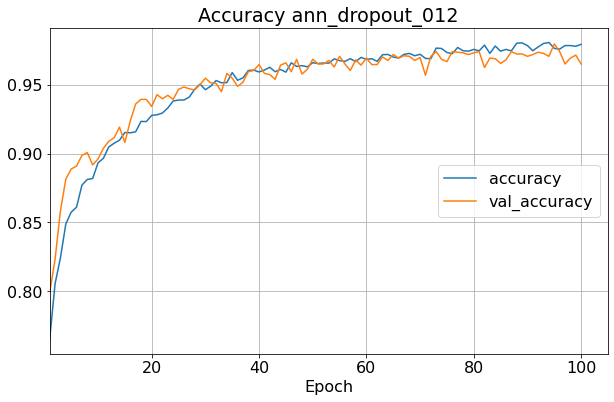

In [42]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [43]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.96943


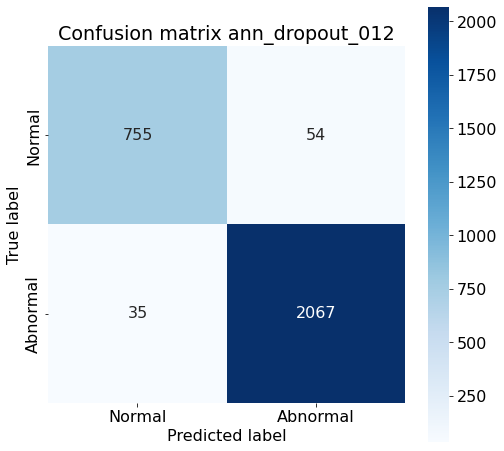

In [44]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [45]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.93325093 0.98334919]
Macro/average accuracy:  0.9583000591584446


In [46]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9557    0.9333    0.9443       809
    Abnormal     0.9745    0.9833    0.9789      2102

    accuracy                         0.9694      2911
   macro avg     0.9651    0.9583    0.9616      2911
weighted avg     0.9693    0.9694    0.9693      2911



### False Positive Rate

In [47]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  35
Percentage of sick persons that are classified as normal:  1.6650808753568032 %


# Dropout with Rate 0.14

In [48]:
name = 'ann_dropout_014'

In [49]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.14))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 0.4898 - accuracy: 0.7605 - val_loss: 0.3774 - val_accuracy: 0.8287
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4111 - accuracy: 0.7988 - val_loss: 0.3751 - val_accuracy: 0.8291
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3847 - accuracy: 0.8218 - val_loss: 0.3090 - val_accuracy: 0.8566
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3570 - accuracy: 0.8293 - val_loss: 0.3106 - val_accuracy: 0.8527
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3360 - accuracy: 0.8425 - val_loss: 0.2839 - val_accuracy: 0.8660
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3135 - accuracy: 0.8522 - val_loss: 0.2581 - val_accuracy: 0.8939
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3020 - accuracy: 0.8610 - val_loss: 0.2530 - val_accuracy: 0.8939

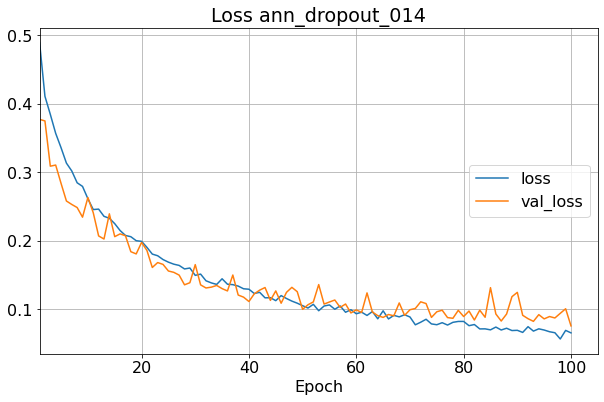

In [51]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

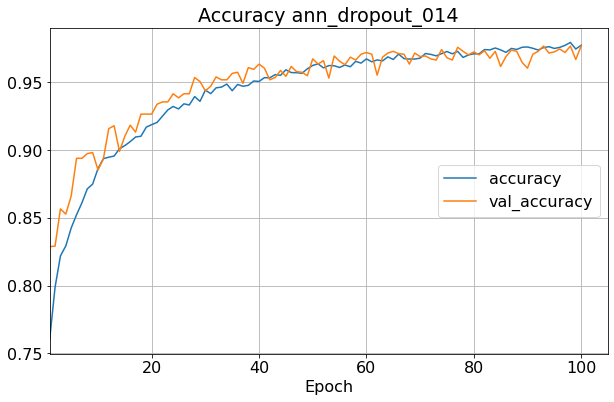

In [52]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [53]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.97561


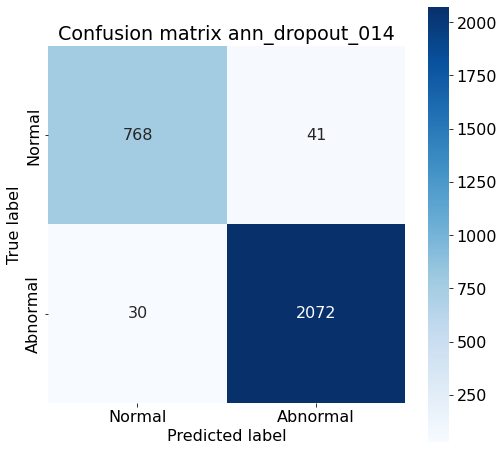

In [54]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [55]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.94932015 0.98572788]
Macro/average accuracy:  0.9675240132712504


In [56]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9624    0.9493    0.9558       809
    Abnormal     0.9806    0.9857    0.9832      2102

    accuracy                         0.9756      2911
   macro avg     0.9715    0.9675    0.9695      2911
weighted avg     0.9755    0.9756    0.9756      2911



### False Positive Rate

In [57]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  30
Percentage of sick persons that are classified as normal:  1.4272121788772598 %


In [58]:
name = 'ann_dropout_016'

In [59]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.Dropout(rate=0.16))
    # AlphaDropout
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 0.5019 - accuracy: 0.7558 - val_loss: 0.3856 - val_accuracy: 0.8085
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4241 - accuracy: 0.8022 - val_loss: 0.3595 - val_accuracy: 0.8291
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3910 - accuracy: 0.8139 - val_loss: 0.3263 - val_accuracy: 0.8510
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3697 - accuracy: 0.8285 - val_loss: 0.3176 - val_accuracy: 0.8690
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3373 - accuracy: 0.8433 - val_loss: 0.2820 - val_accuracy: 0.8695
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3278 - accuracy: 0.8503 - val_loss: 0.3062 - val_accuracy: 0.8639
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3122 - accuracy: 0.8547 - val_loss: 0.3045 - val_accuracy: 0.8690

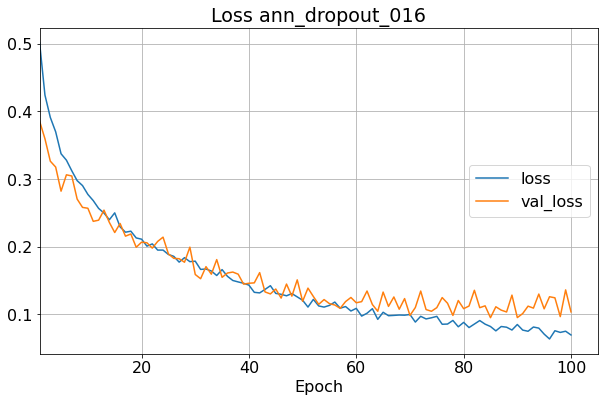

In [61]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

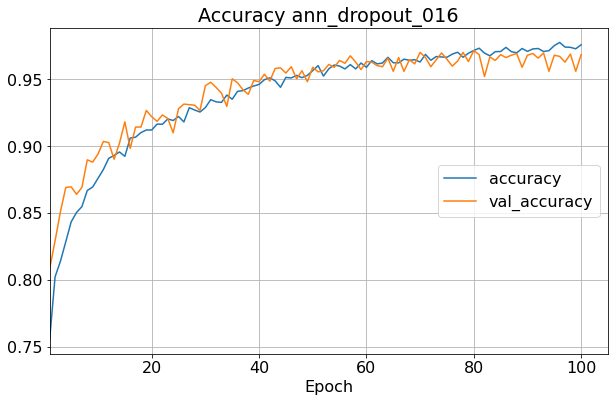

In [62]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [63]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.97321


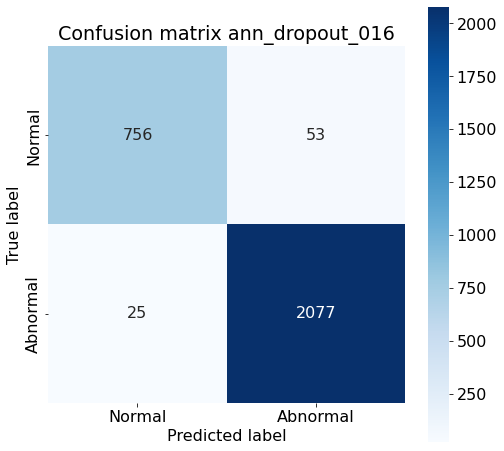

In [64]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [65]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.93448702 0.98810657]
Macro/average accuracy:  0.96129679309481


In [66]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9680    0.9345    0.9509       809
    Abnormal     0.9751    0.9881    0.9816      2102

    accuracy                         0.9732      2911
   macro avg     0.9716    0.9613    0.9663      2911
weighted avg     0.9731    0.9732    0.9731      2911



### False Positive Rate

In [67]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  25
Percentage of sick persons that are classified as normal:  1.1893434823977165 %


# AlphaDropout with Rate 0.08

Alpha dropout remains bad, even if the rate is optimized.

In [18]:
name = 'ann_alphadropout_008'

In [19]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.AlphaDropout(rate=0.08))
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 3s 5ms/step - loss: 0.5334 - accuracy: 0.7270 - val_loss: 0.4084 - val_accuracy: 0.8016
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.4287 - accuracy: 0.7750 - val_loss: 0.3926 - val_accuracy: 0.8025
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.4065 - accuracy: 0.7906 - val_loss: 0.3673 - val_accuracy: 0.8308
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3841 - accuracy: 0.8073 - val_loss: 0.3359 - val_accuracy: 0.8403
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3676 - accuracy: 0.8203 - val_loss: 0.3176 - val_accuracy: 0.8536
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3434 - accuracy: 0.8340 - val_loss: 0.3101 - val_accuracy: 0.8673
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3287 - accuracy: 0.8405 - val_loss: 0.3002 - val_accuracy: 0.8811

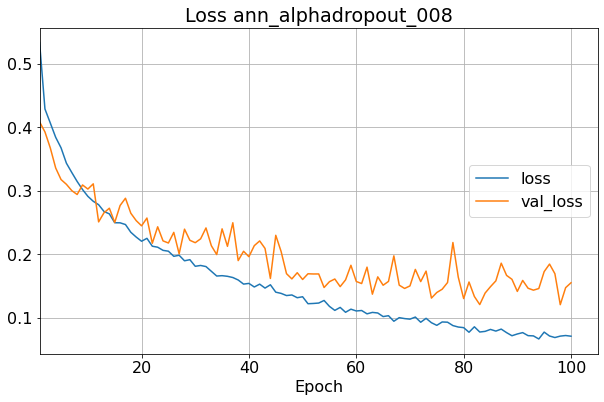

In [21]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

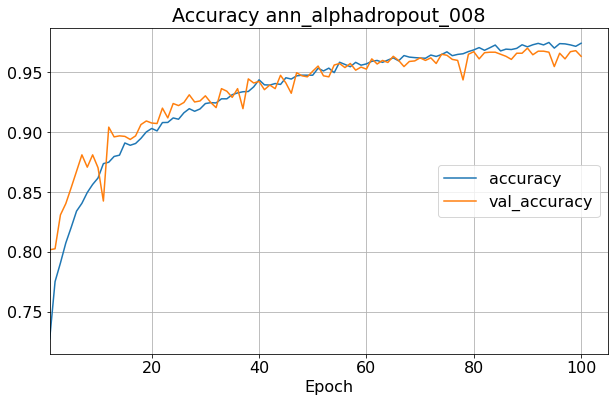

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [23]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.96840


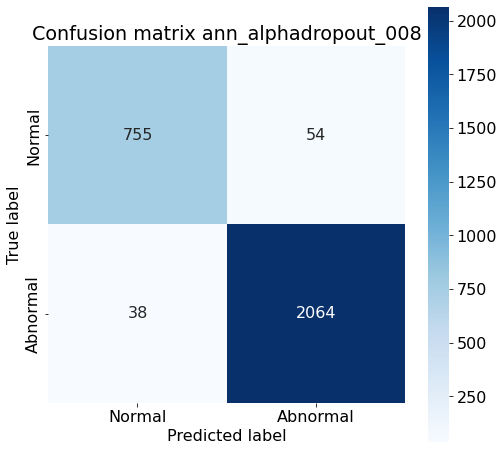

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [25]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.93325093 0.98192198]
Macro/average accuracy:  0.957586453069006


In [26]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9521    0.9333    0.9426       809
    Abnormal     0.9745    0.9819    0.9782      2102

    accuracy                         0.9684      2911
   macro avg     0.9633    0.9576    0.9604      2911
weighted avg     0.9683    0.9684    0.9683      2911



### False Positive Rate

In [27]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  38
Percentage of sick persons that are classified as normal:  1.8078020932445291 %


# AlphaDropout with Rate 0.10

Alpha dropout remains bad, even if the rate is optimized.

In [58]:
name = 'ann_alphadropout_010'

In [59]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.AlphaDropout(rate=0.10))
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [60]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 0.5605 - accuracy: 0.7161 - val_loss: 0.4337 - val_accuracy: 0.7669
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4488 - accuracy: 0.7616 - val_loss: 0.4256 - val_accuracy: 0.7729
Epoch 3/100
291/291 [==============================] - 1s 3ms/step - loss: 0.4224 - accuracy: 0.7744 - val_loss: 0.3939 - val_accuracy: 0.8016
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4121 - accuracy: 0.7852 - val_loss: 0.3899 - val_accuracy: 0.8111
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3936 - accuracy: 0.8006 - val_loss: 0.3674 - val_accuracy: 0.8231
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3849 - accuracy: 0.8101 - val_loss: 0.3481 - val_accuracy: 0.8394
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3636 - accuracy: 0.8259 - val_loss: 0.3153 - val_accuracy: 0.8613

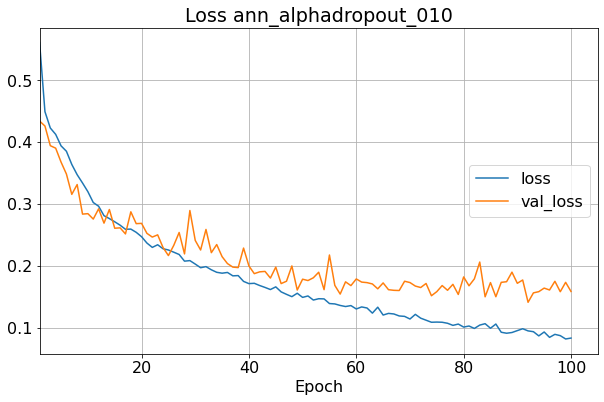

In [61]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

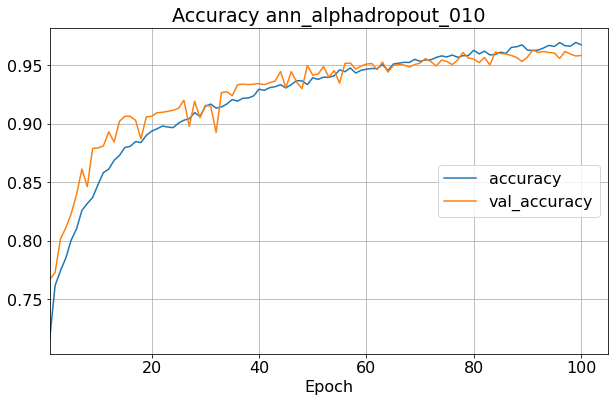

In [62]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [63]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.95362


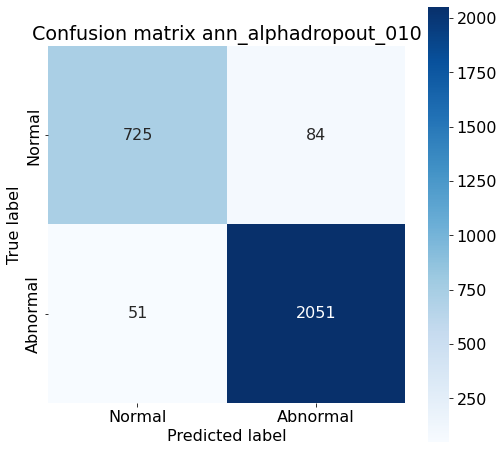

In [64]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [65]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.89616811 0.97573739]
Macro/average accuracy:  0.9359527508676768


In [66]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9343    0.8962    0.9148       809
    Abnormal     0.9607    0.9757    0.9681      2102

    accuracy                         0.9536      2911
   macro avg     0.9475    0.9360    0.9415      2911
weighted avg     0.9533    0.9536    0.9533      2911



### False Positive Rate

In [67]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  51
Percentage of sick persons that are classified as normal:  2.4262607040913418 %


# AlphaDropout with Rate 0.12

Alpha dropout remains bad, even if the rate is optimized.

In [28]:
name = 'ann_alphadropout_012'

In [29]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.AlphaDropout(rate=0.12))
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 3s 4ms/step - loss: 0.5371 - accuracy: 0.7313 - val_loss: 0.4258 - val_accuracy: 0.7982
Epoch 2/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4461 - accuracy: 0.7656 - val_loss: 0.4486 - val_accuracy: 0.7956
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4162 - accuracy: 0.7806 - val_loss: 0.3964 - val_accuracy: 0.8085
Epoch 4/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4080 - accuracy: 0.7913 - val_loss: 0.3825 - val_accuracy: 0.8179
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3932 - accuracy: 0.8046 - val_loss: 0.3853 - val_accuracy: 0.8141
Epoch 6/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3760 - accuracy: 0.8191 - val_loss: 0.4708 - val_accuracy: 0.8240
Epoch 7/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3597 - accuracy: 0.8296 - val_loss: 0.3659 - val_accuracy: 0.8459

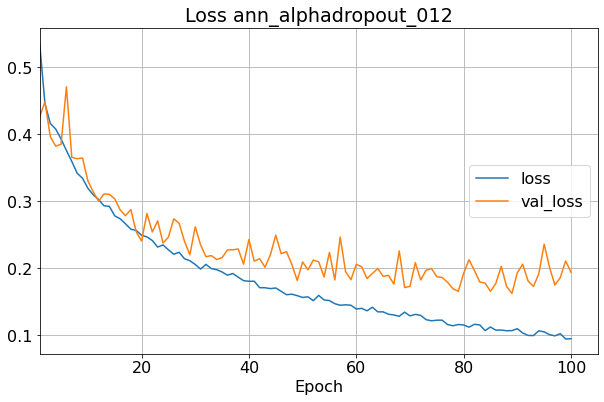

In [31]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

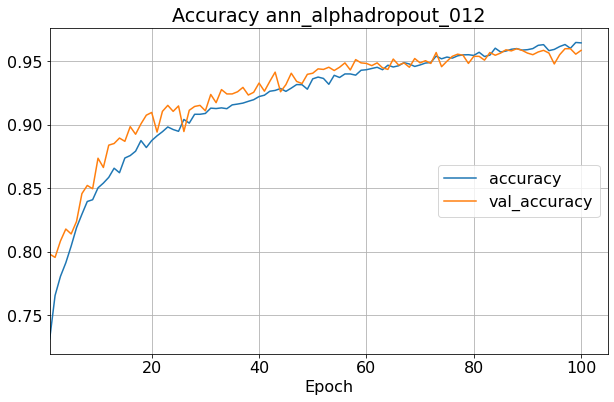

In [32]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [33]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.95294


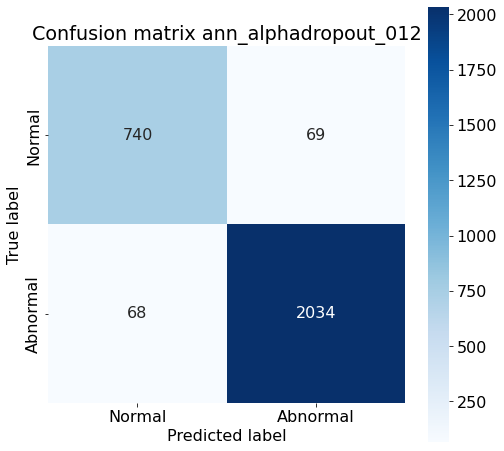

In [34]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [35]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.91470952 0.96764986]
Macro/average accuracy:  0.9411796876010722


In [36]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9158    0.9147    0.9153       809
    Abnormal     0.9672    0.9676    0.9674      2102

    accuracy                         0.9529      2911
   macro avg     0.9415    0.9412    0.9413      2911
weighted avg     0.9529    0.9529    0.9529      2911



### False Positive Rate

In [37]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  68
Percentage of sick persons that are classified as normal:  3.2350142721217887 %


# AlphaDropout with Rate 0.14

Alpha dropout remains bad, even if the rate is optimized.

In [38]:
name = 'ann_alphadropout_014'

In [39]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]
        
# create the model
for i in range(num_layers):
    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
    model.add(tf.keras.layers.AlphaDropout(rate=0.14))
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')


Epoch 1/100
291/291 [==============================] - 2s 3ms/step - loss: 0.5755 - accuracy: 0.7035 - val_loss: 0.4957 - val_accuracy: 0.7827
Epoch 2/100
291/291 [==============================] - 1s 3ms/step - loss: 0.4621 - accuracy: 0.7560 - val_loss: 0.4167 - val_accuracy: 0.7780
Epoch 3/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4380 - accuracy: 0.7656 - val_loss: 0.4062 - val_accuracy: 0.7952
Epoch 4/100
291/291 [==============================] - 1s 3ms/step - loss: 0.4092 - accuracy: 0.7837 - val_loss: 0.3892 - val_accuracy: 0.8218
Epoch 5/100
291/291 [==============================] - 1s 2ms/step - loss: 0.4053 - accuracy: 0.7896 - val_loss: 0.3988 - val_accuracy: 0.8304
Epoch 6/100
291/291 [==============================] - 1s 3ms/step - loss: 0.3910 - accuracy: 0.7968 - val_loss: 0.3527 - val_accuracy: 0.8356
Epoch 7/100
291/291 [==============================] - 1s 2ms/step - loss: 0.3730 - accuracy: 0.8129 - val_loss: 0.3507 - val_accuracy: 0.8454

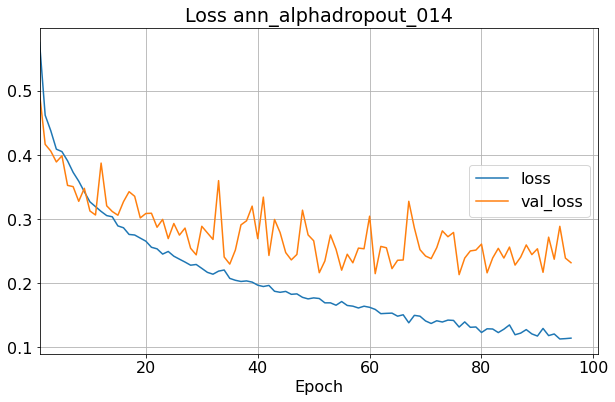

In [41]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

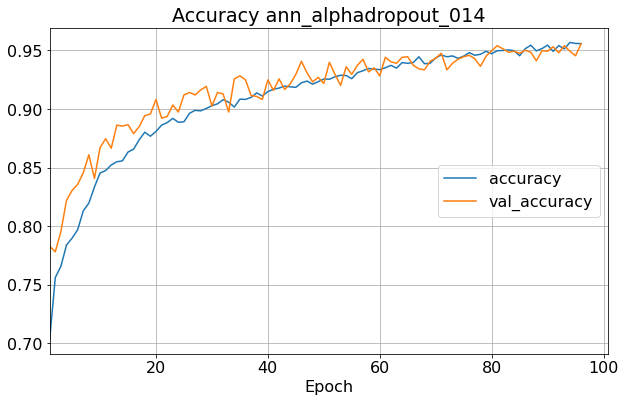

In [42]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [43]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.94297


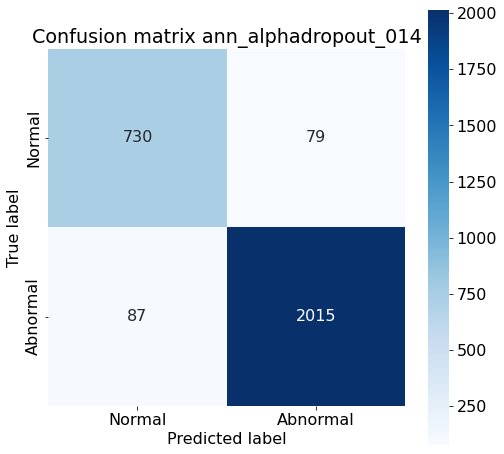

In [44]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [45]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.90234858 0.95861085]
Macro/average accuracy:  0.9304797126522624


In [46]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.8935    0.9023    0.8979       809
    Abnormal     0.9623    0.9586    0.9604      2102

    accuracy                         0.9430      2911
   macro avg     0.9279    0.9305    0.9292      2911
weighted avg     0.9432    0.9430    0.9431      2911



### False Positive Rate

In [47]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  87
Percentage of sick persons that are classified as normal:  4.138915318744053 %


# Batch Normalization

In [48]:
name = 'ann_batch_norm'

In [49]:
model = tf.keras.models.Sequential()
    
num_layers = 5
num_neurons_last_hidden = 16
activation_function='selu'

neur_lst = []
for i in range(num_layers):
    if i == 0:
        neur_lst.append(num_neurons_last_hidden)
    elif i == 1 or i == 2:
        neur_lst.append(num_neurons_last_hidden * (2 ** i))
    elif i == 3:
        neur_lst.append(neur_lst[i-1])
    elif i == 4:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-1)))
    elif i == 5:
        neur_lst.append(neur_lst[i-1])
    elif i == 6:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-2)))
    elif i == 7:
        neur_lst.append(neur_lst[i-1])
    elif i == 8:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-3)))
    elif i == 9:
        neur_lst.append(neur_lst[i-1])
    elif i == 10:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-4)))
    elif i == 11:
        neur_lst.append(neur_lst[i-1])
    elif i == 12:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-5)))
    elif i == 13:
        neur_lst.append(neur_lst[i-1])
    elif i == 14:
        neur_lst.append(num_neurons_last_hidden * (2 ** (i-6)))
    elif i == 15:
        neur_lst.append(neur_lst[i-1])

neur_lst = neur_lst[::-1]

# model.add(tf.keras.layers.Flatten(input_shape=(X_train.shape[1])))
# model.add(tf.keras.layers.BatchNormalization())

# create the model
for i in range(num_layers):

    if i == 0:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function, input_dim=X_train.shape[1]))
        model.add(tf.keras.layers.BatchNormalization())
    else:
        model.add(tf.keras.layers.Dense(neur_lst[i], activation=activation_function))
        model.add(tf.keras.layers.BatchNormalization())
    
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 4s 5ms/step - loss: 0.4237 - accuracy: 0.8033 - val_loss: 0.3320 - val_accuracy: 0.8626
Epoch 2/100
291/291 [==============================] - 1s 4ms/step - loss: 0.2958 - accuracy: 0.8724 - val_loss: 0.2824 - val_accuracy: 0.8841
Epoch 3/100
291/291 [==============================] - 1s 4ms/step - loss: 0.2572 - accuracy: 0.8911 - val_loss: 0.2182 - val_accuracy: 0.9141
Epoch 4/100
291/291 [==============================] - 1s 4ms/step - loss: 0.2324 - accuracy: 0.9009 - val_loss: 0.1938 - val_accuracy: 0.9188
Epoch 5/100
291/291 [==============================] - 1s 3ms/step - loss: 0.2091 - accuracy: 0.9152 - val_loss: 0.2103 - val_accuracy: 0.9188
Epoch 6/100
291/291 [==============================] - 1s 4ms/step - loss: 0.1882 - accuracy: 0.9253 - val_loss: 0.1544 - val_accuracy: 0.9416
Epoch 7/100
291/291 [==============================] - 1s 4ms/step - loss: 0.1738 - accuracy: 0.9307 - val_loss: 0.1460 - val_accuracy: 0.9463

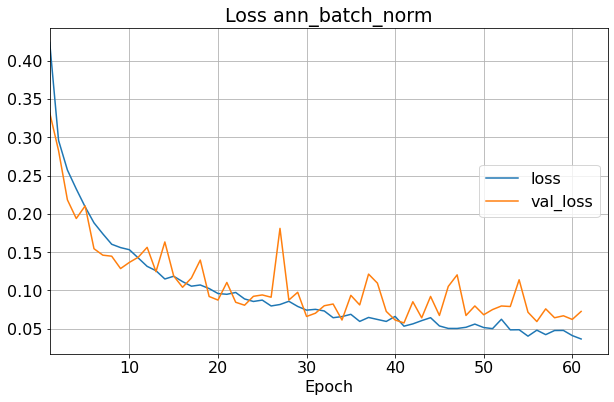

In [51]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

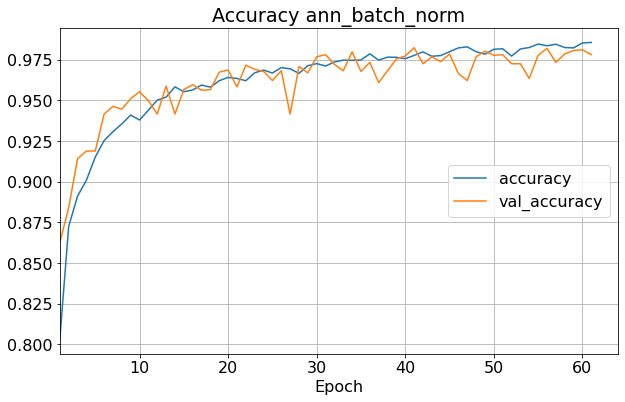

In [52]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [53]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.97767


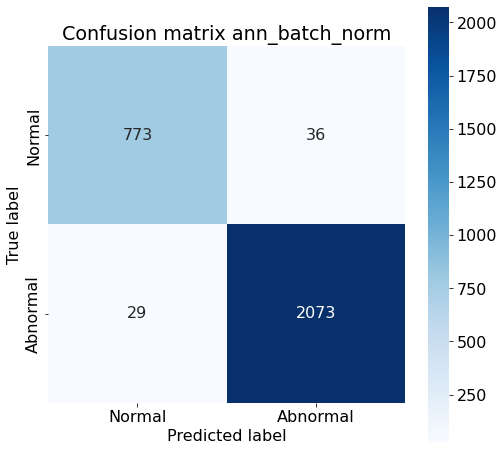

In [54]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [55]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.95550062 0.98620362]
Macro/average accuracy:  0.970852116825579


In [56]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9638    0.9555    0.9597       809
    Abnormal     0.9829    0.9862    0.9846      2102

    accuracy                         0.9777      2911
   macro avg     0.9734    0.9709    0.9721      2911
weighted avg     0.9776    0.9777    0.9776      2911



### False Positive Rate

In [57]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  29
Percentage of sick persons that are classified as normal:  1.379638439581351 %


# CNN

# Batch Normalization - added for dense layers

In [18]:
name = 'cnn_batch_norm_dense'

In [29]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 10s 30ms/step - loss: 0.2804 - accuracy: 0.8886 - val_loss: 0.9828 - val_accuracy: 0.5419
Epoch 2/100
291/291 [==============================] - 9s 30ms/step - loss: 0.1172 - accuracy: 0.9580 - val_loss: 0.3493 - val_accuracy: 0.8617
Epoch 3/100
291/291 [==============================] - 8s 28ms/step - loss: 0.0878 - accuracy: 0.9697 - val_loss: 0.3082 - val_accuracy: 0.8862
Epoch 4/100
291/291 [==============================] - 8s 28ms/step - loss: 0.0671 - accuracy: 0.9756 - val_loss: 0.4245 - val_accuracy: 0.8660
Epoch 5/100
291/291 [==============================] - 9s 29ms/step - loss: 0.0482 - accuracy: 0.9830 - val_loss: 0.0626 - val_accuracy: 0.9777
Epoch 6/100
291/291 [==============================] - 9s 30ms/step - loss: 0.0360 - accuracy: 0.9875 - val_loss: 0.0657 - val_accuracy: 0.9764
Epoch 7/100
291/291 [==============================] - 8s 29ms/step - loss: 0.0292 - accuracy: 0.9898 - val_loss: 0.0623 - val_accuracy

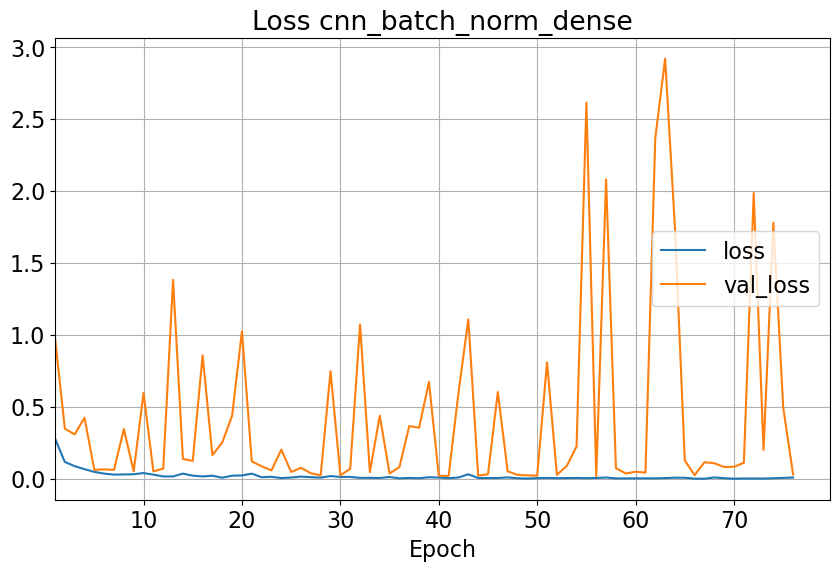

In [21]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

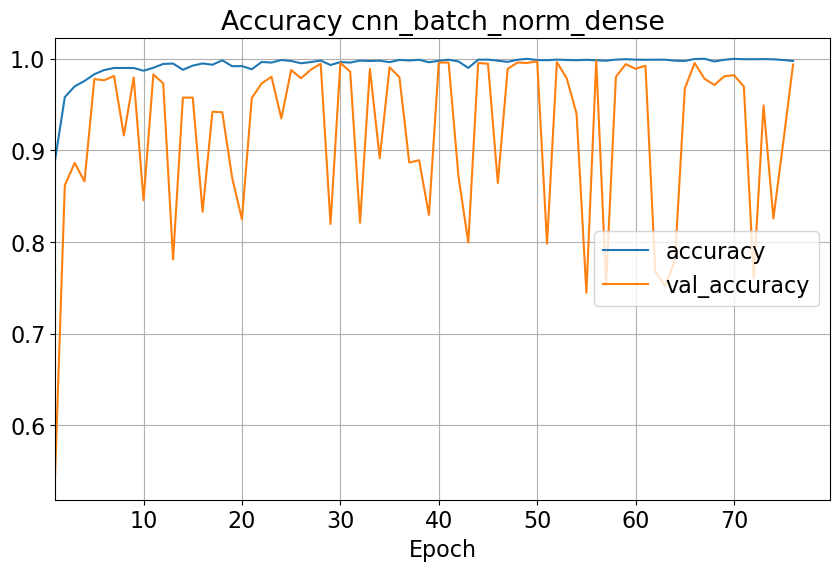

In [22]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [32]:
X_test.shape

(2911, 187)

In [31]:
# Predict test set labels
y_pred_proba = model.predict(X_test)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

91/91 [==============================] - 1s 8ms/step
Accuracy: 0.99519


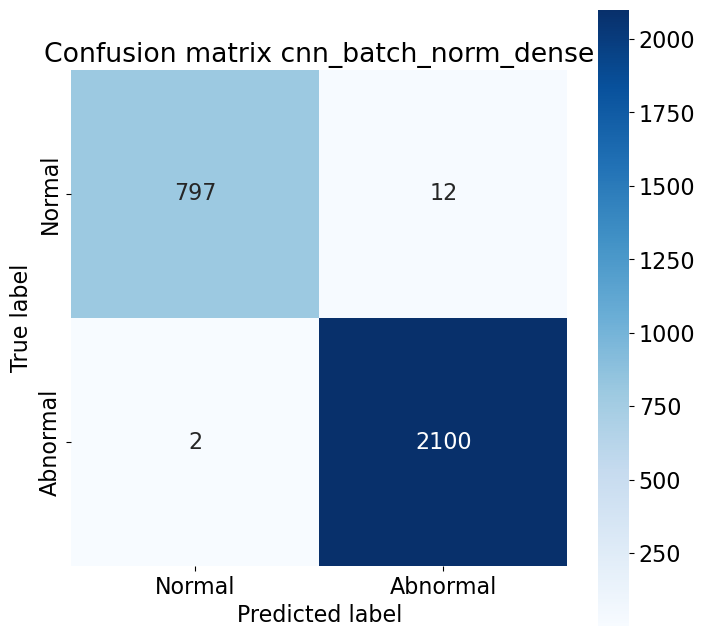

In [24]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [25]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.98516687 0.99904853]
Macro/average accuracy:  0.9921076989482028


In [26]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9975    0.9852    0.9913       809
    Abnormal     0.9943    0.9990    0.9967      2102

    accuracy                         0.9952      2911
   macro avg     0.9959    0.9921    0.9940      2911
weighted avg     0.9952    0.9952    0.9952      2911



### False Positive Rate

In [27]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  2
Percentage of sick persons that are classified as normal:  0.09514747859181732 %


# Dropout with Rate 0.08

In [32]:
name = 'cnn_dropout_008'

In [33]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

rate = 0.08

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))
    model.add(tf.keras.layers.Dropout(rate=rate))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=rate))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [34]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 12s 36ms/step - loss: 0.3422 - accuracy: 0.8504 - val_loss: 1.3156 - val_accuracy: 0.7218
Epoch 2/100
291/291 [==============================] - 11s 39ms/step - loss: 0.1514 - accuracy: 0.9419 - val_loss: 1.1438 - val_accuracy: 0.7316
Epoch 3/100
291/291 [==============================] - 11s 38ms/step - loss: 0.0927 - accuracy: 0.9656 - val_loss: 0.1911 - val_accuracy: 0.9227
Epoch 4/100
291/291 [==============================] - 11s 37ms/step - loss: 0.0737 - accuracy: 0.9748 - val_loss: 0.4640 - val_accuracy: 0.8536
Epoch 5/100
291/291 [==============================] - 10s 33ms/step - loss: 0.0627 - accuracy: 0.9799 - val_loss: 0.1525 - val_accuracy: 0.9459
Epoch 6/100
291/291 [==============================] - 11s 37ms/step - loss: 0.0343 - accuracy: 0.9892 - val_loss: 0.8678 - val_accuracy: 0.8377
Epoch 7/100
291/291 [==============================] - 11s 38ms/step - loss: 0.0482 - accuracy: 0.9835 - val_loss: 0.3367 - val_ac

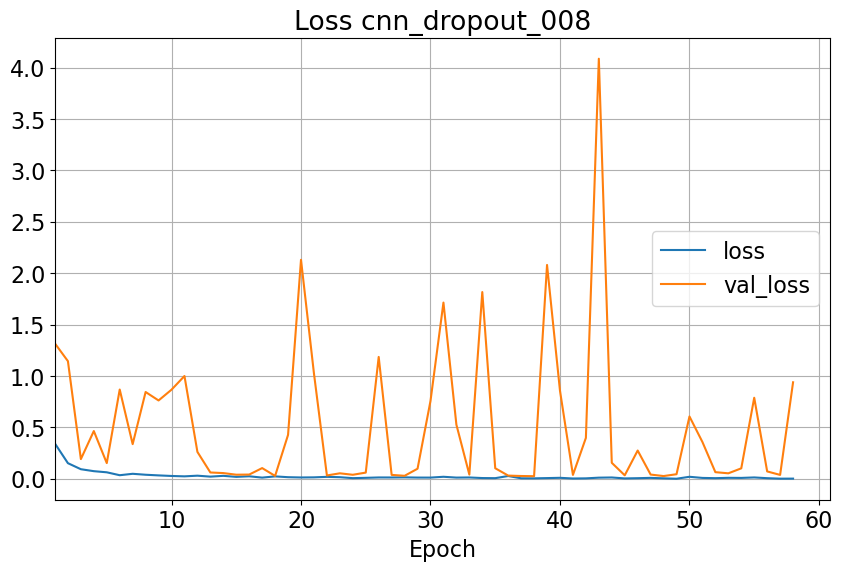

In [35]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

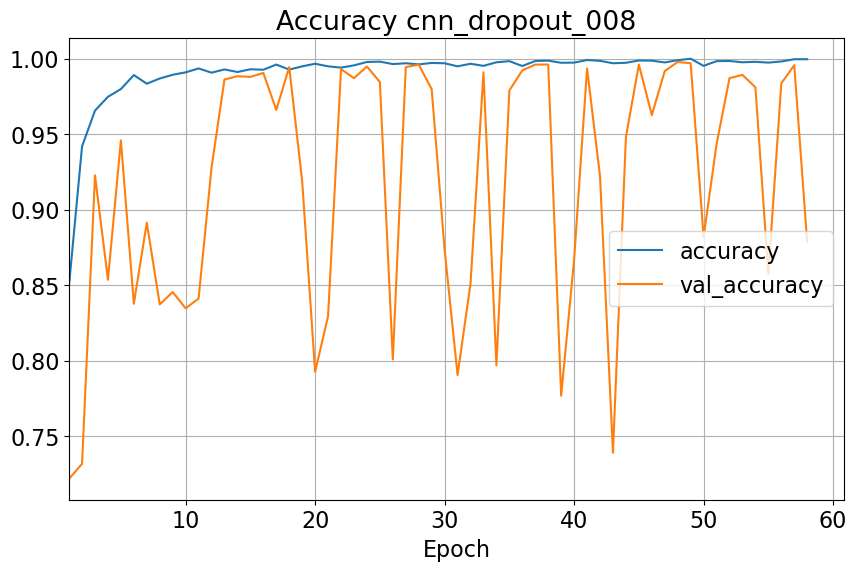

In [36]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [37]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.99107


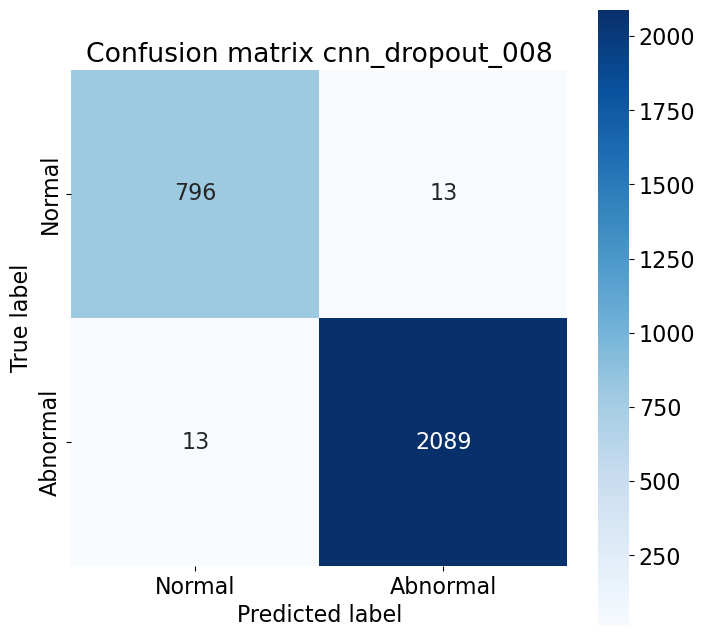

In [38]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [39]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.98393078 0.99381541]
Macro/average accuracy:  0.988873096315358


In [40]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9839    0.9839    0.9839       809
    Abnormal     0.9938    0.9938    0.9938      2102

    accuracy                         0.9911      2911
   macro avg     0.9889    0.9889    0.9889      2911
weighted avg     0.9911    0.9911    0.9911      2911



### False Positive Rate

In [41]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  13
Percentage of sick persons that are classified as normal:  0.6184586108468125 %


# Dropout with Rate 0.10

In [42]:
name = 'cnn_dropout_010'

In [43]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

rate = 0.10

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))
    model.add(tf.keras.layers.Dropout(rate=rate))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=rate))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [44]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 11s 34ms/step - loss: 0.3604 - accuracy: 0.8475 - val_loss: 2.0309 - val_accuracy: 0.7218
Epoch 2/100
291/291 [==============================] - 10s 33ms/step - loss: 0.1571 - accuracy: 0.9399 - val_loss: 0.5188 - val_accuracy: 0.7819
Epoch 3/100
291/291 [==============================] - 10s 34ms/step - loss: 0.1018 - accuracy: 0.9627 - val_loss: 0.8943 - val_accuracy: 0.7742
Epoch 4/100
291/291 [==============================] - 9s 33ms/step - loss: 0.0684 - accuracy: 0.9767 - val_loss: 0.6261 - val_accuracy: 0.8540
Epoch 5/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0591 - accuracy: 0.9811 - val_loss: 0.2791 - val_accuracy: 0.9124
Epoch 6/100
291/291 [==============================] - 10s 33ms/step - loss: 0.0489 - accuracy: 0.9827 - val_loss: 0.1596 - val_accuracy: 0.9360
Epoch 7/100
291/291 [==============================] - 10s 33ms/step - loss: 0.0354 - accuracy: 0.9878 - val_loss: 0.2207 - val_acc

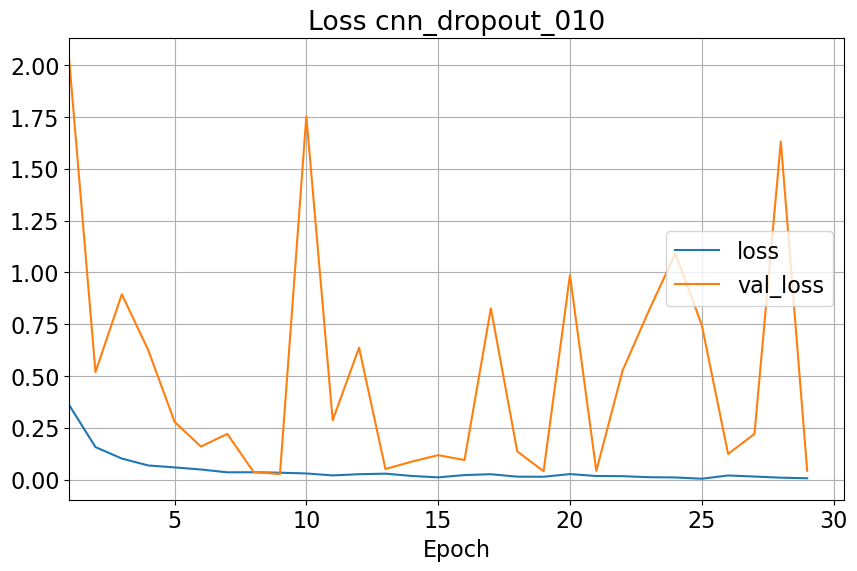

In [45]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

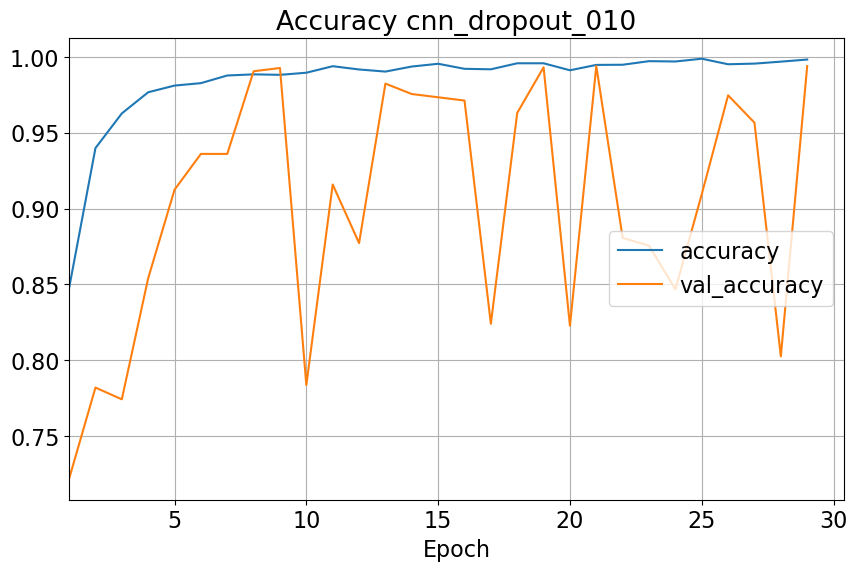

In [46]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [47]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.98660


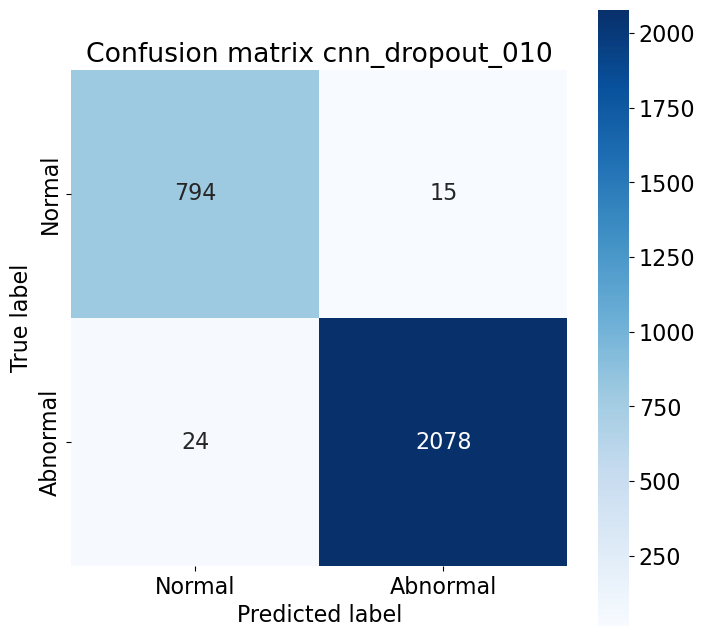

In [48]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [49]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.98145859 0.9885823 ]
Macro/average accuracy:  0.9850204467109434


In [50]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9707    0.9815    0.9760       809
    Abnormal     0.9928    0.9886    0.9907      2102

    accuracy                         0.9866      2911
   macro avg     0.9817    0.9850    0.9834      2911
weighted avg     0.9867    0.9866    0.9866      2911



### False Positive Rate

In [51]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  24
Percentage of sick persons that are classified as normal:  1.141769743101808 %


# Dropout with Rate 0.12

In [52]:
name = 'cnn_dropout_012'

In [53]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

rate = 0.12

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))
    model.add(tf.keras.layers.Dropout(rate=rate))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=rate))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [54]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 11s 36ms/step - loss: 0.3544 - accuracy: 0.8454 - val_loss: 0.5437 - val_accuracy: 0.7149
Epoch 2/100
291/291 [==============================] - 10s 34ms/step - loss: 0.1750 - accuracy: 0.9285 - val_loss: 0.2256 - val_accuracy: 0.8961
Epoch 3/100
291/291 [==============================] - 10s 33ms/step - loss: 0.1102 - accuracy: 0.9590 - val_loss: 0.3458 - val_accuracy: 0.8630
Epoch 4/100
291/291 [==============================] - 10s 36ms/step - loss: 0.0843 - accuracy: 0.9713 - val_loss: 0.2676 - val_accuracy: 0.8729
Epoch 5/100
291/291 [==============================] - 10s 36ms/step - loss: 0.0679 - accuracy: 0.9767 - val_loss: 0.9209 - val_accuracy: 0.7626
Epoch 6/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0524 - accuracy: 0.9806 - val_loss: 0.1093 - val_accuracy: 0.9614
Epoch 7/100
291/291 [==============================] - 10s 36ms/step - loss: 0.0413 - accuracy: 0.9843 - val_loss: 0.1239 - val_ac

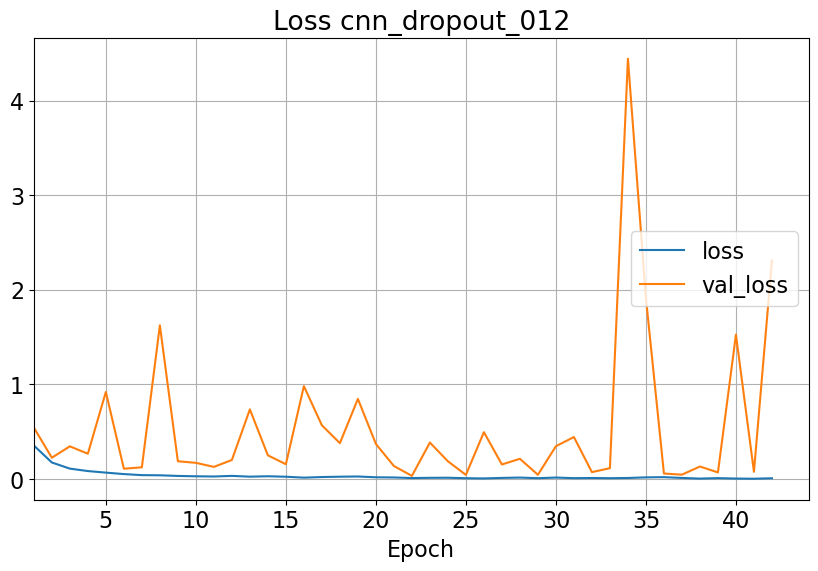

In [55]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

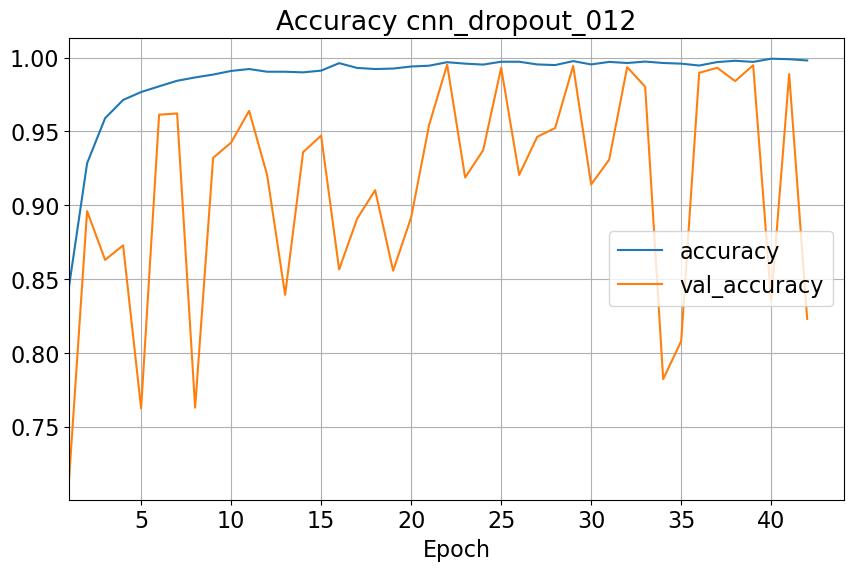

In [56]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [57]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.99244


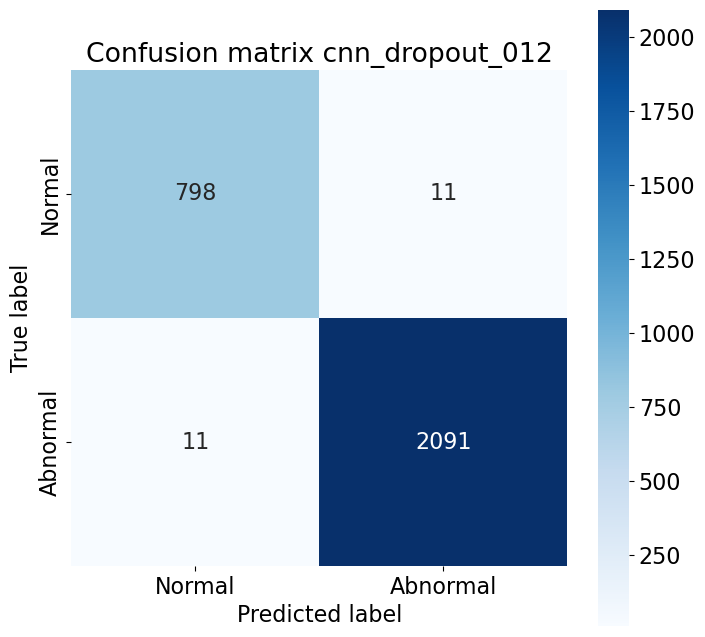

In [58]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [59]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.98640297 0.99476689]
Macro/average accuracy:  0.9905849276514568


In [60]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9864    0.9864    0.9864       809
    Abnormal     0.9948    0.9948    0.9948      2102

    accuracy                         0.9924      2911
   macro avg     0.9906    0.9906    0.9906      2911
weighted avg     0.9924    0.9924    0.9924      2911



### False Positive Rate

In [61]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  11
Percentage of sick persons that are classified as normal:  0.5233111322549953 %


# Dropout with Rate 0.14

In [62]:
name = 'cnn_dropout_014'

In [63]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

rate = 0.14

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))
    model.add(tf.keras.layers.Dropout(rate=rate))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.Dropout(rate=rate))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 12s 36ms/step - loss: 0.3869 - accuracy: 0.8301 - val_loss: 0.5219 - val_accuracy: 0.6921
Epoch 2/100
291/291 [==============================] - 10s 36ms/step - loss: 0.1741 - accuracy: 0.9313 - val_loss: 0.4956 - val_accuracy: 0.7707
Epoch 3/100
291/291 [==============================] - 10s 35ms/step - loss: 0.1292 - accuracy: 0.9535 - val_loss: 0.3077 - val_accuracy: 0.9008
Epoch 4/100
291/291 [==============================] - 10s 35ms/step - loss: 0.1020 - accuracy: 0.9631 - val_loss: 0.1851 - val_accuracy: 0.9287
Epoch 5/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0687 - accuracy: 0.9759 - val_loss: 0.6379 - val_accuracy: 0.8248
Epoch 6/100
291/291 [==============================] - 10s 35ms/step - loss: 0.0499 - accuracy: 0.9827 - val_loss: 0.0600 - val_accuracy: 0.9802
Epoch 7/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0555 - accuracy: 0.9810 - val_loss: 0.1123 - val_ac

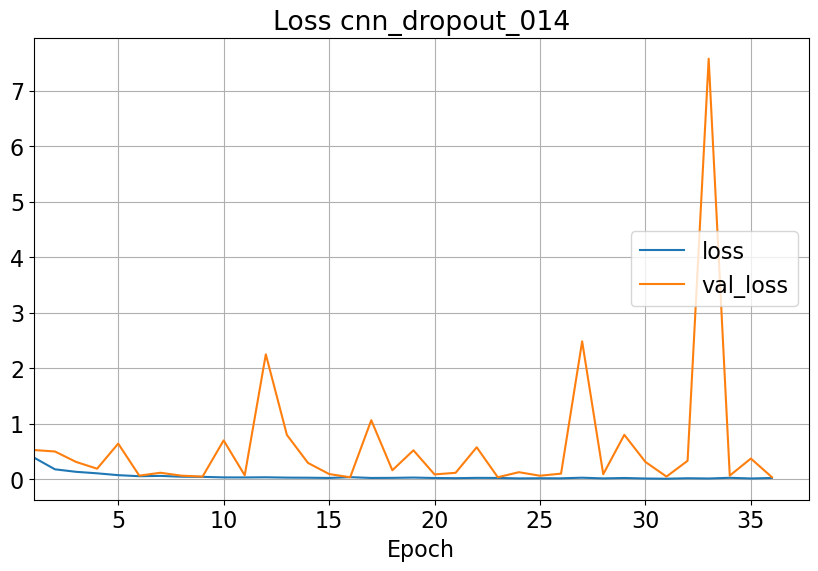

In [65]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

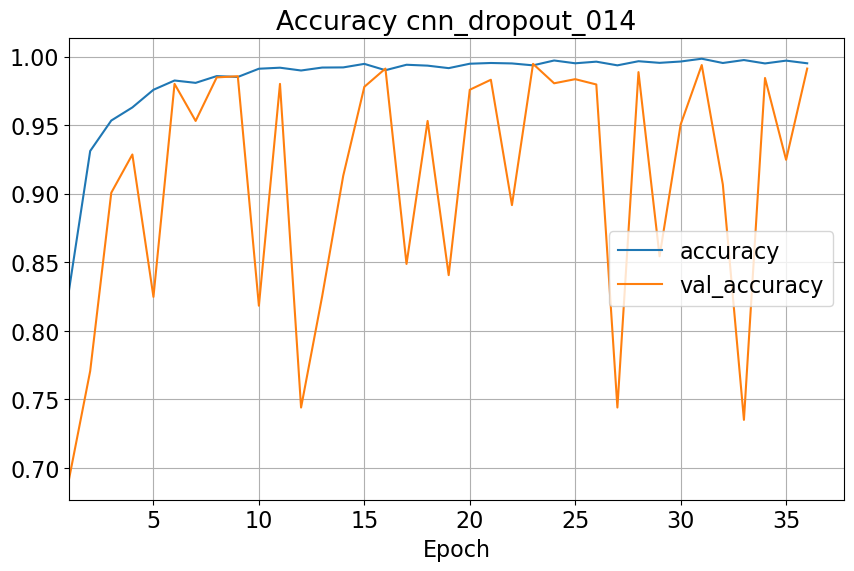

In [66]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [67]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.99072


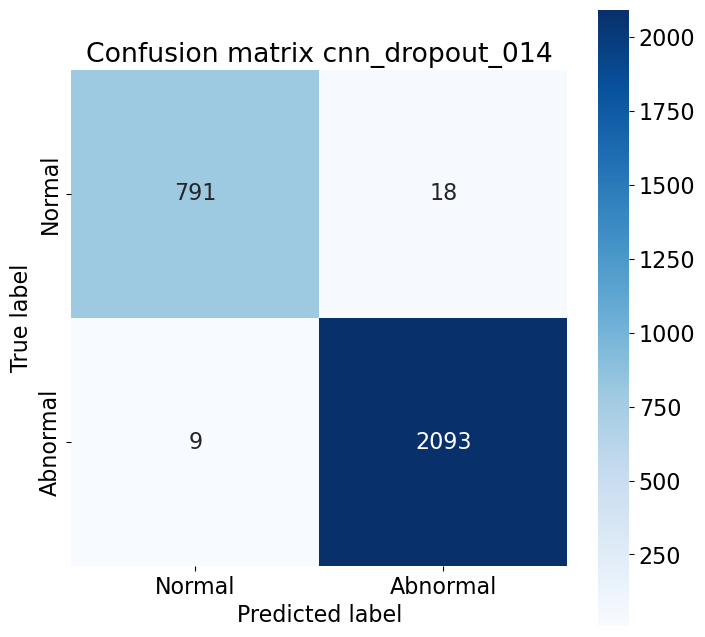

In [68]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [69]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.97775031 0.99571836]
Macro/average accuracy:  0.986734336243427


In [70]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9888    0.9778    0.9832       809
    Abnormal     0.9915    0.9957    0.9936      2102

    accuracy                         0.9907      2911
   macro avg     0.9901    0.9867    0.9884      2911
weighted avg     0.9907    0.9907    0.9907      2911



### False Positive Rate

In [71]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  9
Percentage of sick persons that are classified as normal:  0.4281636536631779 %


# Alpha Dropout with Rate 0.08

In [72]:
name = 'cnn_alphadropout_008'

In [73]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

rate = 0.08

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))
    model.add(tf.keras.layers.AlphaDropout(rate=rate))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.AlphaDropout(rate=rate))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [74]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 11s 35ms/step - loss: 0.4211 - accuracy: 0.7928 - val_loss: 0.8596 - val_accuracy: 0.6196
Epoch 2/100
291/291 [==============================] - 10s 35ms/step - loss: 0.2314 - accuracy: 0.9040 - val_loss: 0.5855 - val_accuracy: 0.8647
Epoch 3/100
291/291 [==============================] - 10s 36ms/step - loss: 0.1553 - accuracy: 0.9402 - val_loss: 0.1987 - val_accuracy: 0.9626
Epoch 4/100
291/291 [==============================] - 10s 34ms/step - loss: 0.1172 - accuracy: 0.9547 - val_loss: 0.0743 - val_accuracy: 0.9824
Epoch 5/100
291/291 [==============================] - 10s 33ms/step - loss: 0.0867 - accuracy: 0.9681 - val_loss: 0.6195 - val_accuracy: 0.9137
Epoch 6/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0749 - accuracy: 0.9715 - val_loss: 0.0981 - val_accuracy: 0.9815
Epoch 7/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0538 - accuracy: 0.9790 - val_loss: 0.1189 - val_ac

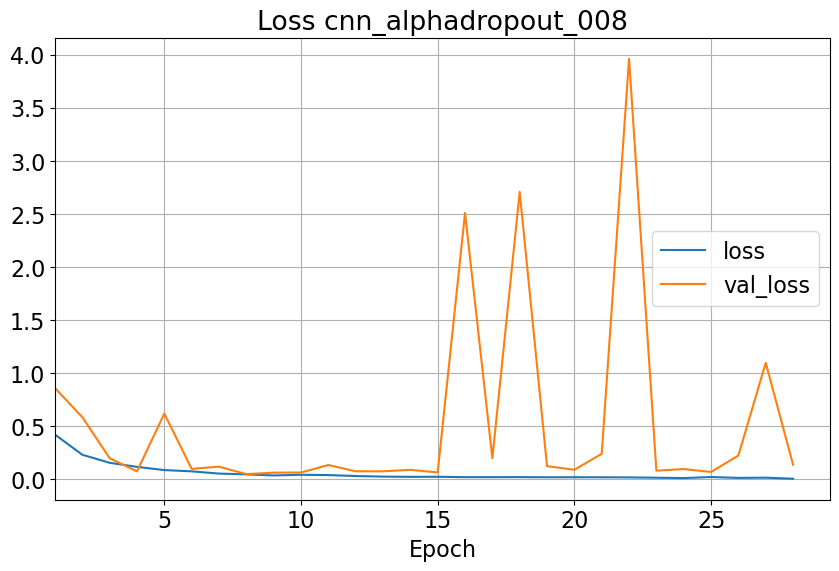

In [75]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

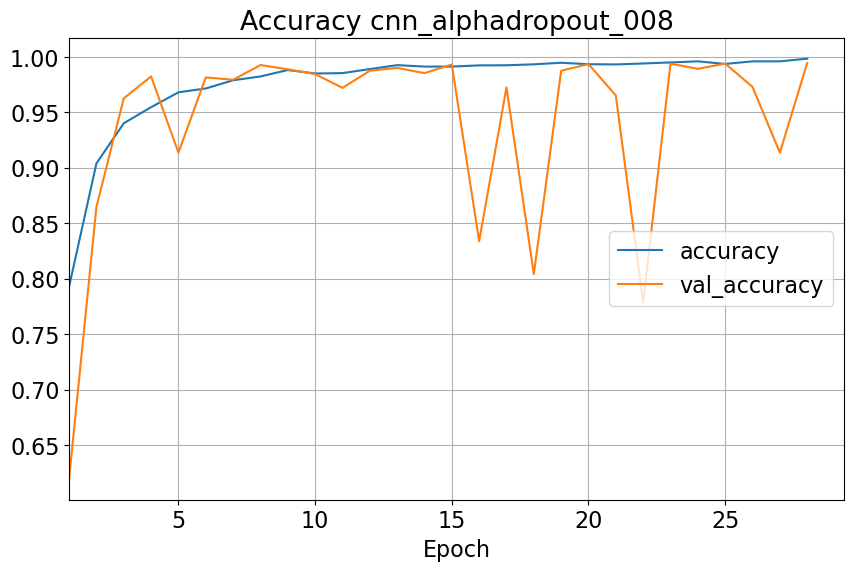

In [76]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [77]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.98626


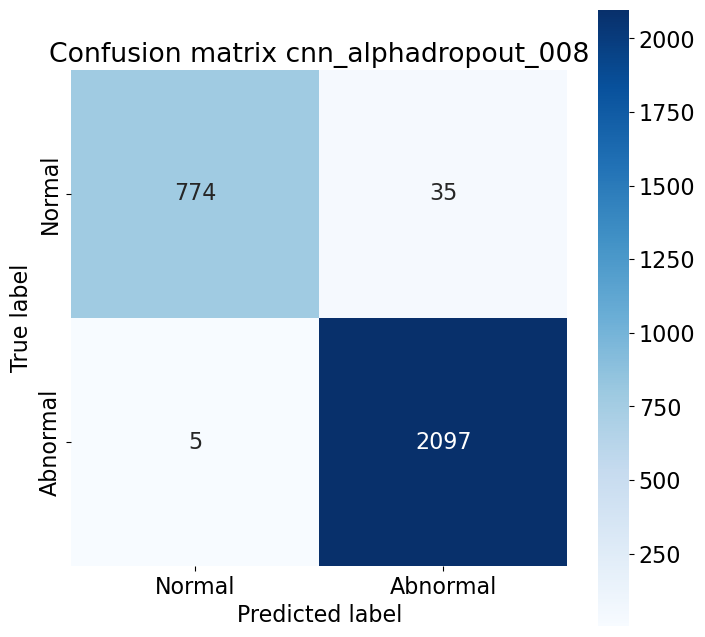

In [78]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [79]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.95673671 0.99762131]
Macro/average accuracy:  0.9771790125126578


In [80]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9936    0.9567    0.9748       809
    Abnormal     0.9836    0.9976    0.9906      2102

    accuracy                         0.9863      2911
   macro avg     0.9886    0.9772    0.9827      2911
weighted avg     0.9864    0.9863    0.9862      2911



### False Positive Rate

In [81]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  5
Percentage of sick persons that are classified as normal:  0.23786869647954328 %


# Alpha Dropout with Rate 0.10

In [82]:
name = 'cnn_alphadropout_010'

In [83]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

rate = 0.10

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))
    model.add(tf.keras.layers.AlphaDropout(rate=rate))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.AlphaDropout(rate=rate))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [84]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 12s 38ms/step - loss: 0.4401 - accuracy: 0.7902 - val_loss: 2.9510 - val_accuracy: 0.2830
Epoch 2/100
291/291 [==============================] - 11s 37ms/step - loss: 0.2596 - accuracy: 0.8866 - val_loss: 1.0677 - val_accuracy: 0.7815
Epoch 3/100
291/291 [==============================] - 10s 35ms/step - loss: 0.1831 - accuracy: 0.9259 - val_loss: 0.2215 - val_accuracy: 0.9523
Epoch 4/100
291/291 [==============================] - 11s 37ms/step - loss: 0.1400 - accuracy: 0.9458 - val_loss: 0.3163 - val_accuracy: 0.9343
Epoch 5/100
291/291 [==============================] - 10s 34ms/step - loss: 0.1094 - accuracy: 0.9595 - val_loss: 0.1756 - val_accuracy: 0.9725
Epoch 6/100
291/291 [==============================] - 10s 35ms/step - loss: 0.0885 - accuracy: 0.9683 - val_loss: 0.1072 - val_accuracy: 0.9790
Epoch 7/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0722 - accuracy: 0.9734 - val_loss: 0.1266 - val_ac

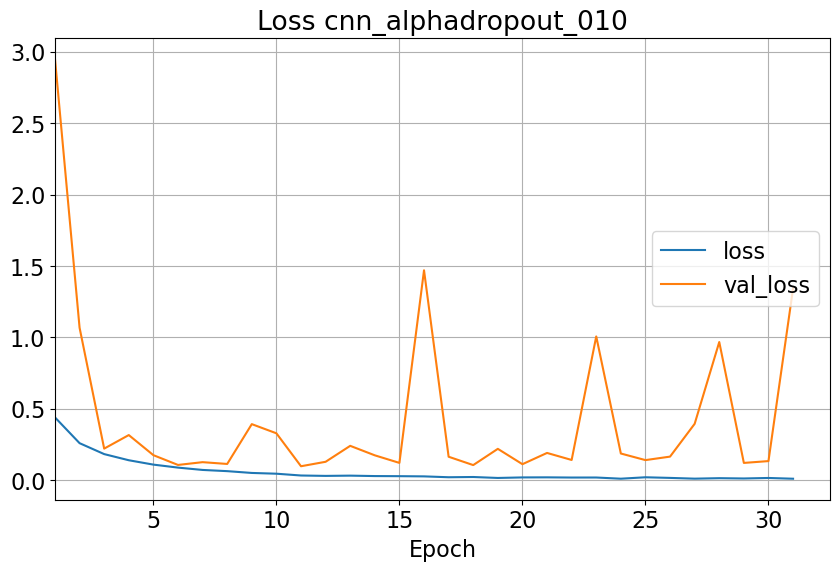

In [85]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

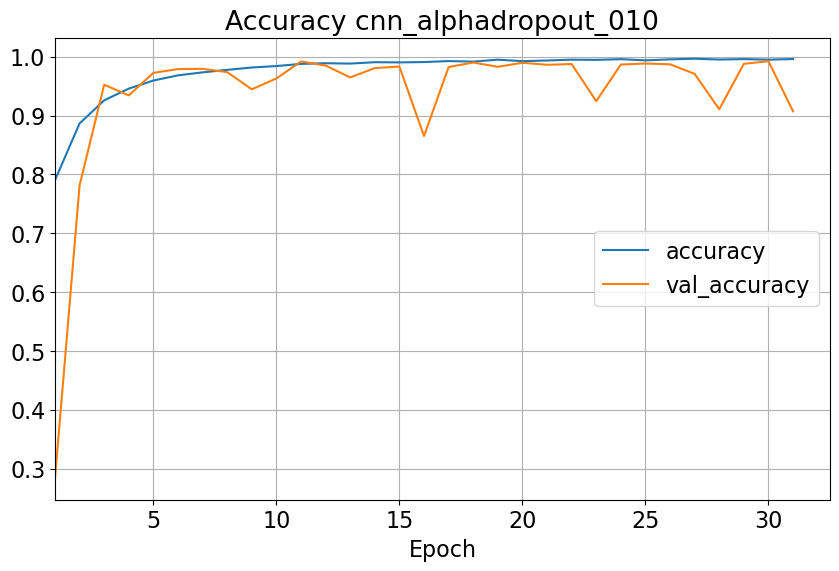

In [86]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [87]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.98729


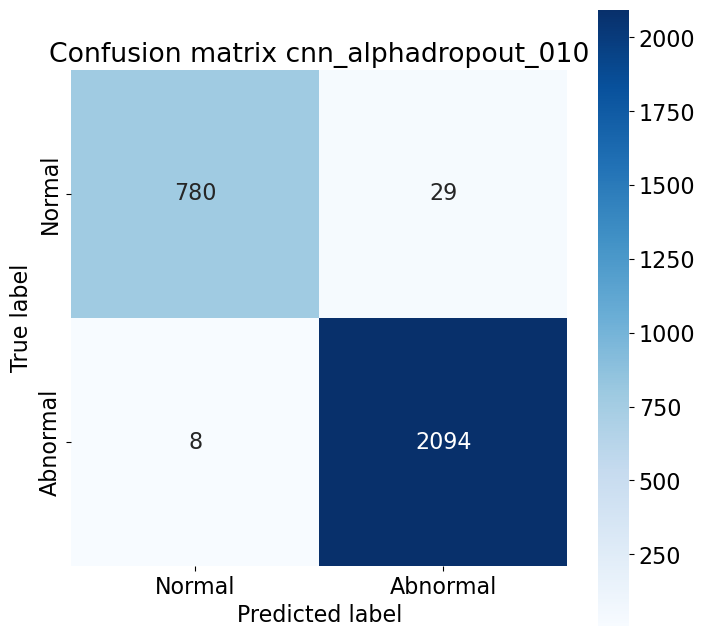

In [88]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [89]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.96415328 0.9961941 ]
Macro/average accuracy:  0.9801736882526384


In [90]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9898    0.9642    0.9768       809
    Abnormal     0.9863    0.9962    0.9912      2102

    accuracy                         0.9873      2911
   macro avg     0.9881    0.9802    0.9840      2911
weighted avg     0.9873    0.9873    0.9872      2911



### False Positive Rate

In [91]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  8
Percentage of sick persons that are classified as normal:  0.3805899143672693 %


# Alpha Dropout with Rate 0.12

In [92]:
name = 'cnn_alphadropout_012'

In [93]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

rate = 0.12

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))
    model.add(tf.keras.layers.AlphaDropout(rate=rate))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.AlphaDropout(rate=rate))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [94]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 12s 35ms/step - loss: 0.4326 - accuracy: 0.7940 - val_loss: 7.6318 - val_accuracy: 0.2782
Epoch 2/100
291/291 [==============================] - 10s 34ms/step - loss: 0.2741 - accuracy: 0.8853 - val_loss: 1.0849 - val_accuracy: 0.7484
Epoch 3/100
291/291 [==============================] - 10s 33ms/step - loss: 0.2003 - accuracy: 0.9185 - val_loss: 2.6017 - val_accuracy: 0.7557
Epoch 4/100
291/291 [==============================] - 10s 33ms/step - loss: 0.1559 - accuracy: 0.9408 - val_loss: 0.1933 - val_accuracy: 0.9579
Epoch 5/100
291/291 [==============================] - 10s 34ms/step - loss: 0.1305 - accuracy: 0.9468 - val_loss: 0.5610 - val_accuracy: 0.9249
Epoch 6/100
291/291 [==============================] - 11s 37ms/step - loss: 0.1078 - accuracy: 0.9581 - val_loss: 0.2721 - val_accuracy: 0.9523
Epoch 7/100
291/291 [==============================] - 10s 35ms/step - loss: 0.0891 - accuracy: 0.9657 - val_loss: 0.3744 - val_ac

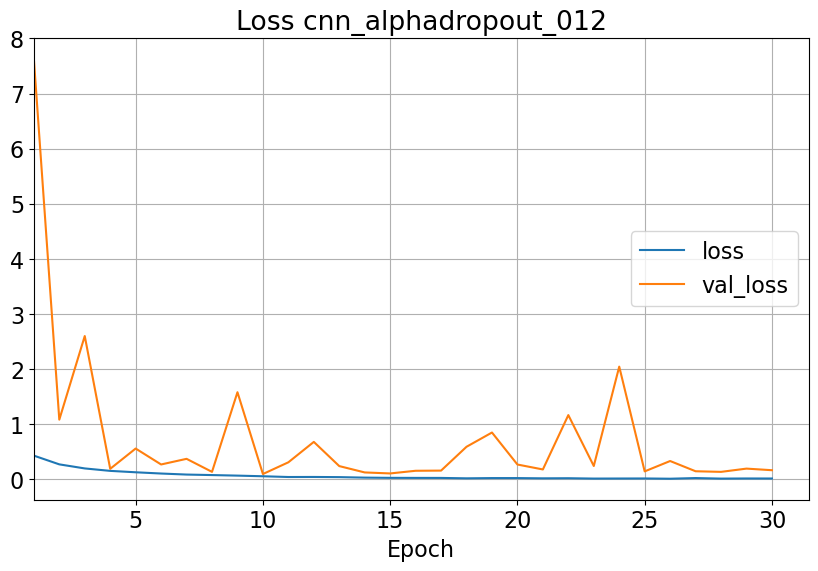

In [95]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

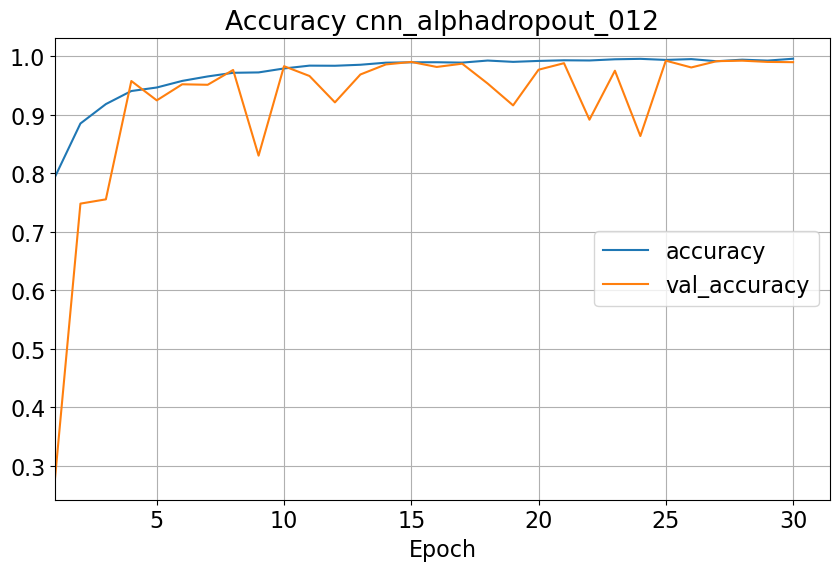

In [96]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [97]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.98179


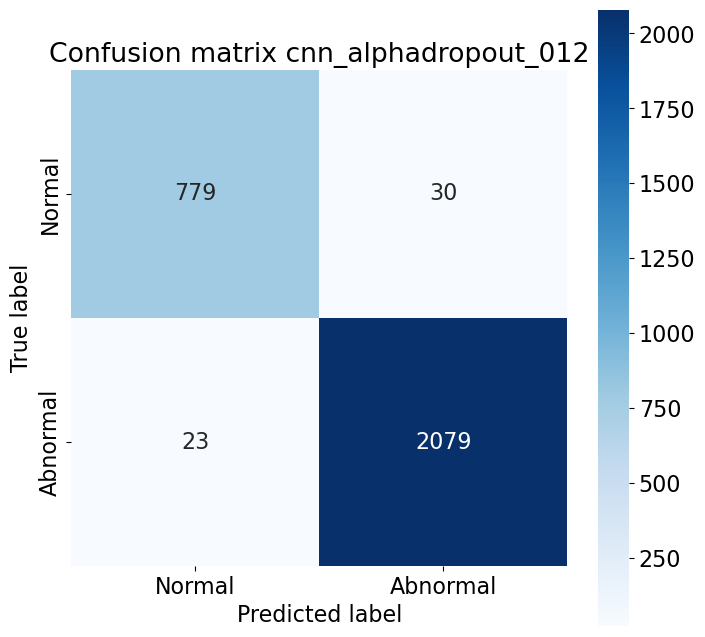

In [98]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [99]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.96291718 0.98905804]
Macro/average accuracy:  0.9759876108338753


In [100]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9713    0.9629    0.9671       809
    Abnormal     0.9858    0.9891    0.9874      2102

    accuracy                         0.9818      2911
   macro avg     0.9785    0.9760    0.9773      2911
weighted avg     0.9818    0.9818    0.9818      2911



### False Positive Rate

In [101]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  23
Percentage of sick persons that are classified as normal:  1.0941960038058993 %


# Alpha Dropout with Rate 0.14

In [102]:
name = 'cnn_alphadropout_014'

In [103]:
model = tf.keras.models.Sequential()

num_conv_blocks=3
strides=1
num_dense_layers=3
num_neurons_last_hidden=64

rate = 0.14

pool_sizes = [2, 2, 3, 3, 4, 4]
masked_pools = pool_sizes[0:num_conv_blocks][::-1]

kernel_sizes = [3, 3, 6, 6, 9, 9]
masked_kernels = kernel_sizes[0:num_conv_blocks][::-1]

# Convolutional blocks
for i in range(num_conv_blocks):
    if i == 0:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu', input_shape=(X_train.shape[1],1)))
    else:
        model.add(Convolution1D(64, (masked_kernels[i]), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(pool_size=(masked_pools[i]), strides=(strides), padding="same"))
    model.add(tf.keras.layers.AlphaDropout(rate=rate))

# Flatten layer
model.add(Flatten())

# Dense layers
max_neurons = num_neurons_last_hidden * (2 ** (num_dense_layers - 1))
for i in range(num_dense_layers):
    neurons = max_neurons / (2 ** i)
    model.add(Dense(neurons, activation='relu'))
    model.add(tf.keras.layers.AlphaDropout(rate=rate))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [104]:
callbacks = [EarlyStopping(monitor='val_loss', patience=20),
            ModelCheckpoint(filepath = 'train_model.h5', monitor='val_loss', save_best_only=True)]

# train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=callbacks, batch_size=32, epochs=100, verbose=1)

model.load_weights('train_model.h5')
save_model(model, name, 'keras')

Epoch 1/100
291/291 [==============================] - 12s 38ms/step - loss: 0.4911 - accuracy: 0.7537 - val_loss: 1.0525 - val_accuracy: 0.5706
Epoch 2/100
291/291 [==============================] - 11s 38ms/step - loss: 0.3117 - accuracy: 0.8631 - val_loss: 0.3431 - val_accuracy: 0.9120
Epoch 3/100
291/291 [==============================] - 11s 36ms/step - loss: 0.2125 - accuracy: 0.9156 - val_loss: 0.2669 - val_accuracy: 0.9468
Epoch 4/100
291/291 [==============================] - 10s 36ms/step - loss: 0.1633 - accuracy: 0.9366 - val_loss: 0.1914 - val_accuracy: 0.9588
Epoch 5/100
291/291 [==============================] - 10s 36ms/step - loss: 0.1223 - accuracy: 0.9561 - val_loss: 0.2007 - val_accuracy: 0.9687
Epoch 6/100
291/291 [==============================] - 10s 34ms/step - loss: 0.0966 - accuracy: 0.9643 - val_loss: 0.1462 - val_accuracy: 0.9815
Epoch 7/100
291/291 [==============================] - 10s 36ms/step - loss: 0.0753 - accuracy: 0.9723 - val_loss: 0.4102 - val_ac

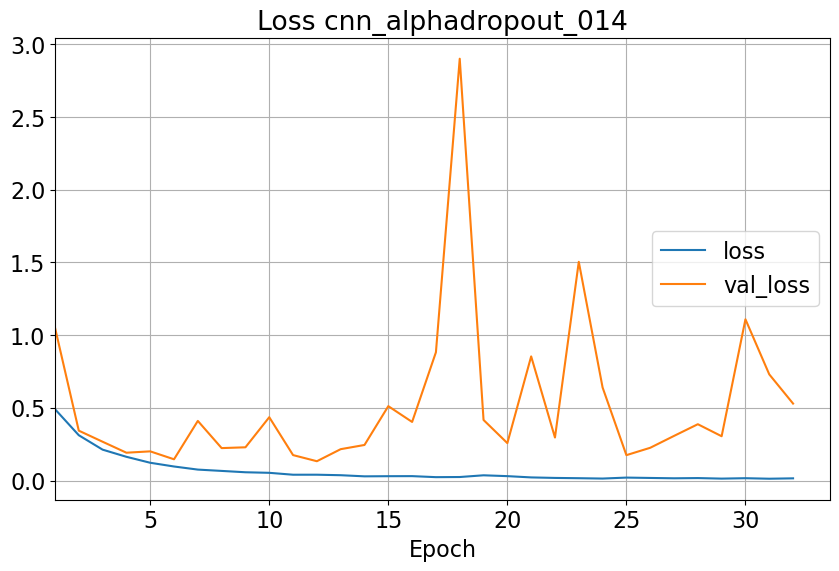

In [105]:
history_df = pd.DataFrame(history.history)
history_df.index += 1

cols = ['loss', 'val_loss']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Loss ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

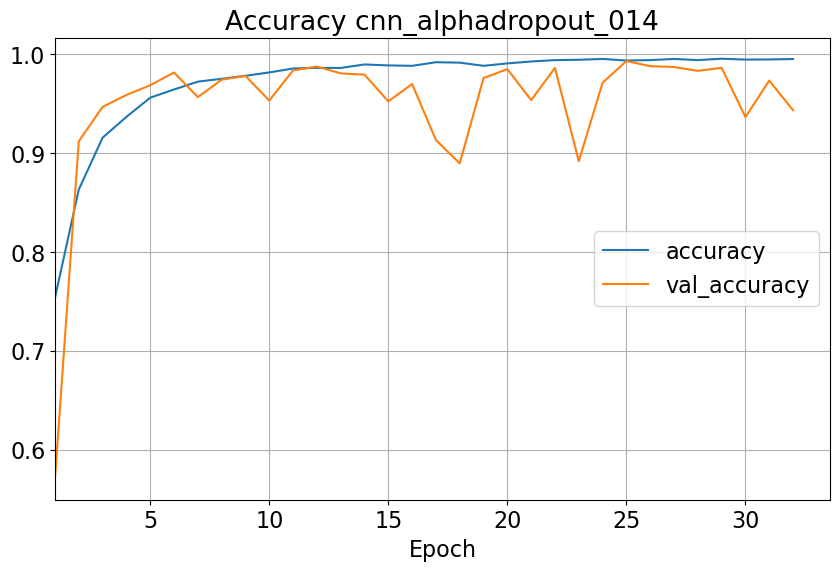

In [106]:
cols = ['accuracy', 'val_accuracy']

plt.figure(figsize=(10,6))
plt.plot(history_df[cols])
plt.grid(True)
plt.xlabel('Epoch')
plt.gca().set_xlim(left=1)
plt_title = 'Accuracy ' + name
plt.title(plt_title)
plt.legend(cols, loc="right")
plt.show()

### Evaluation

In [107]:
# Predict test set labels
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = np.where(y_pred_proba > 0.5, 1, 0)

# Model Accuracy: how often is the classifier correct?
print(f'Accuracy: {accuracy_score(y_test, y_pred):.5f}')

Accuracy: 0.98488


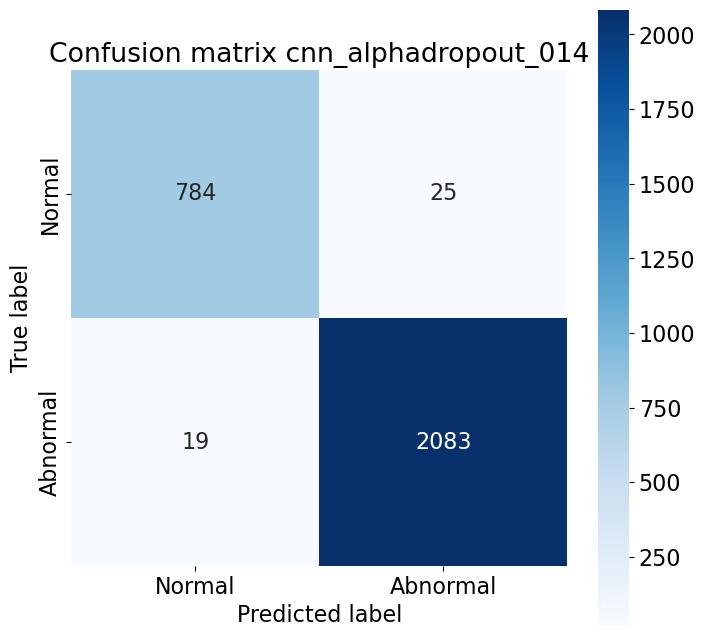

In [108]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8,8))
ax = plt.subplot(111)
sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap='Blues', square=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt_title = 'Confusion matrix ' + name
plt.title(plt_title)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.show()

In [109]:
# Calculate the accurcay for each label
acc_per_class = cm.diagonal()/cm.sum(axis=1)
print('Accuracy per class: ', acc_per_class)
# Take the avearge of the accuracies
acc = np.mean(acc_per_class)
print('Macro/average accuracy: ', acc)

Accuracy per class:  [0.96909765 0.99096099]
Macro/average accuracy:  0.9800293204776427


In [110]:
report = classification_report(y_test, y_pred, target_names=labels, digits=4)
print(report)

# Create the classification report table
results_table_latex(cm, report, name, 2)

              precision    recall  f1-score   support

      Normal     0.9763    0.9691    0.9727       809
    Abnormal     0.9881    0.9910    0.9895      2102

    accuracy                         0.9849      2911
   macro avg     0.9822    0.9800    0.9811      2911
weighted avg     0.9849    0.9849    0.9849      2911



### False Positive Rate

In [111]:
num_classes = cm.shape[0]
total_abnormal= 0
total_wrong_predicted = 0
for i in range(num_classes-1): 
    total_abnormal_class = np.sum(cm[i+1, :])
    total_abnormal = total_abnormal + total_abnormal_class

    wrong_predicted = np.sum(cm[i+1, 0])
    total_wrong_predicted = total_wrong_predicted + wrong_predicted

print("Total number of abnormal instances: ", total_abnormal)
print("Total number of wrong predicted abnormal instances: ", total_wrong_predicted)
print("Percentage of sick persons that are classified as normal: ", wrong_predicted/total_abnormal_class*100, "%")    

Total number of abnormal instances:  2102
Total number of wrong predicted abnormal instances:  19
Percentage of sick persons that are classified as normal:  0.9039010466222646 %
